# 使用注意力机制的Seq2Seq

动机
- 机器翻译中，每个生成的词可能相关于源句子中不同的词
- Seq2Seq模型不能对此直接建模

加入注意力
- 编码器对每次词的输出作为key和value
- 解码器RNN对上一个词的输出是query
- 注意力的输出和下一个词的词嵌入合并进入RNN

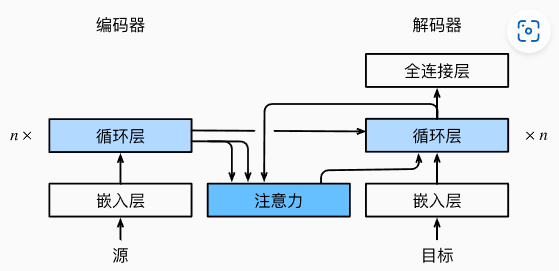

总结
- Seq2Seq中通过隐状态在编码器和解码器中传递信息
- 注意力机制可以根据解码器RNN的输出来匹配到合适的编码器RNN的输出来更有效地传递信息

In [1]:
#Bahdanau注意力
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

d:\Anaconda\envs\d2l-zh\lib\site-packages\torch\_subclasses\functional_tensor.py:258: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [2]:
#定义注意力编码器
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

In [3]:
#实现带有Bahdanau注意力机制的循环神经网络解码器
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout= 0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, 
                                               num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, 
                          dropout= dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        #outputs的形状(batch_size, num_steps, num_hiddens)
        #hidden_state的形状(num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        #enc_outputs的形状为(batch_size, num_steps, num_hiddens)
        #hidden_state的形状为(num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        #输出X的形状为(batch_size, batch_size, num_hiddens)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            #query的形状为(batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim= 1)
            #context的形状为(batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, 
                                     enc_outputs, enc_valid_lens)
            #在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim= 1)), dim= -1)
            #将x变形为(1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            #记录解码器输出以及注意力权重
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        #使用全连接层计算整个模型输出
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights
    

In [4]:
#测试Bahdanau注意力解码器
encoder = d2l.Seq2SeqEncoder(vocab_size= 10, embed_size= 8, 
                             num_hiddens= 16, num_layers= 2)
encoder.eval()
#(batch_size, num_steps)
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size= 8, 
                                  num_hiddens= 16, num_layers= 2)
X = torch.zeros((4, 7), dtype= torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.019, 1923.1 tokens/sec on cuda:0


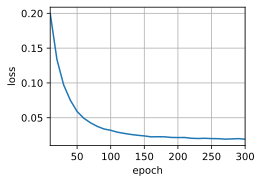

In [5]:
#进行训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 5*1e-3, 300, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [6]:
#执行句子翻译并计算BLEU分数
engs = ['go .', 'i lost .', 'he\'s clam .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, 
        src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng}=> {translation}, ', f'bleu {d2l.bleu(translation, fra, k= 2):.3f}')

go .=> va !,  bleu 1.000
i lost .=> j'ai perdu .,  bleu 1.000
he's clam .=> il est <unk> .,  bleu 0.658
i'm home .=> je suis chez moi .,  bleu 1.000
